# Exploring Superfund Site Data

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
from shapely.geometry import Polygon
from shapely.geometry import mapping

import warnings
warnings.simplefilter(action='ignore')

In [2]:
#change default figure size
plt.rcParams['figure.figsize'] = (20, 10)

I found an Esri Geodatabase of Superfund sites, and used the command line to first convert this into a geojson.

`ogr2ogr -f "GeoJSON" superfund-sites-original.geojson SuperfundSites.gdb`

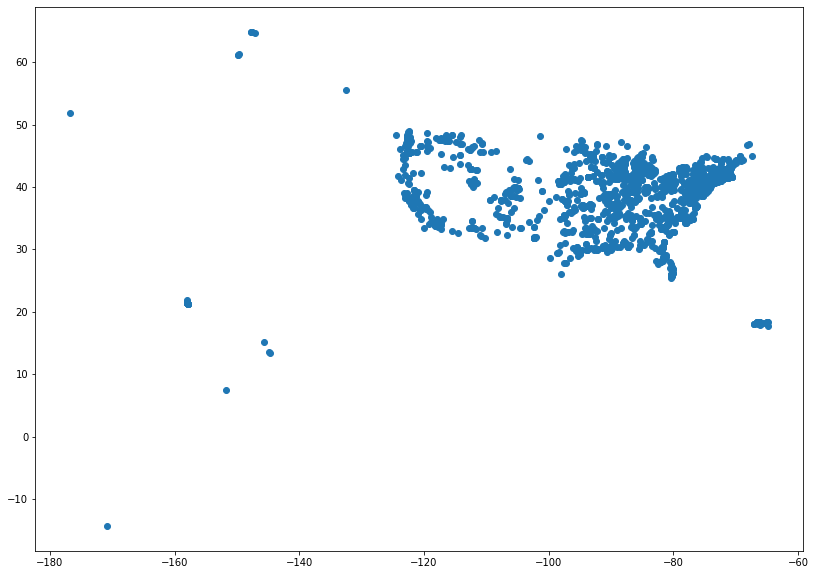

In [3]:
#read superfund site shapefile in
gdf = gpd.read_file('../data/superfund-sites-original.geojson')

#plot data to visualize
%matplotlib inline
gdf.plot(figsize=(20,10));

In [4]:
#inspect attribute table
gdf.sample(10)

,siteID,EPASiteID,EPARegion,siteName,streetAddress,cityName,state,zipCode,countyName,FIPSCode,congressionalDistrict,nationalPrioritiesListStatus,nonNationalPrioritiesListStatus,federalFacilityStatus,geometry
983,500634,ILD980606750,5,Ottawa Radiation Areas,"RTE 6 & RTE 71, Ottawa Area",Ottawa,IL,61350,La Salle,17099.0,11.0,Currently on the Final NPL,None,N,POINT (-88.83611 41.35166)
873,401428,GAD042101261,4,T.H. Agriculture & Nutrition Co. (Albany Plant),1401 Schley Ave,Albany,GA,31707,Dougherty,13095.0,8.0,Currently on the Final NPL,None,N,POINT (-84.18166 31.61736)
1606,800078,COD007063530,8,"ASARCO, Inc. (Globe Plant)",495 East 51st Avenue,Denver,CO,80216,Adams,8001.0,1.0,Removed from Proposed NPL,None,N,POINT (-104.98028 39.79333)
1324,600428,LAD052510344,6,Delatte Metals,1541 Weinberger Road,Ponchatoula,LA,70454,Tangipahoa,22105.0,1.0,Deleted from the Final NPL,None,N,POINT (-90.41083 30.42250)
490,204234,NYSFN0204234,2,Old Roosevelt Field Contaminated GW Area,Clinton Road/Old Country Road,Garden City,NY,11530,Nassau,36059.0,4.0,Currently on the Final NPL,None,N,POINT (-73.61847 40.73361)
835,401932,KYD006371074,4,General Tire & Rubber Co. (Mayfield Landfill),1 General St,Mayfield,KY,42066,Graves,21083.0,1.0,Deleted from the Final NPL,None,N,POINT (-88.63580 36.79060)
1967,701747,MO2210090054,7,Lake City AAP - 139 W Central Portion,139 W Central Portion HWY 78,Independence,MO,64050,Jackson,29095.0,4.0,Site is Part of NPL Site,None,Y,POINT (-94.41833 39.09333)
2055,1000546,OR6213820917,10,Umatilla Army Depot (Lagoons),I-84 & Exit 178,Hermiston,OR,97844,Morrow,41049.0,2.0,Currently on the Final NPL,None,Y,POINT (-119.45000 45.83611)
1231,500219,ILD006114151,5,Warner Electric Brake & Clutch Co.,449 Gardner St,Roscoe,IL,61073,Winnebago,17201.0,16.0,Removed from Proposed NPL,None,N,POINT (-89.01333 42.44000)
1826,700145,IAD039954300,7,PCE Former Dry Cleaner,1205 East 7th Street,Atlantic,IA,50022,Cass,19029.0,4.0,Currently on the Final NPL,None,N,POINT (-94.99576 41.40372)


Unfortunately there is not a whole lot of data here. We have basic location information (EPA region, site name, address, county, etc.) but no data on what type of threats each site poses.

The field "nationalPrioritiesListStatus" is worth paying attention to. According to the EPA's [Superfund Site](https://www.epa.gov/superfund/superfund-national-priorities-list-npl), "The National Priorities List (NPL) is the list of sites of national priority among the known releases or threatened releases of hazardous substances, pollutants, or contaminants throughout the United States and its territories." Sites are deleted from the NPL if the EPA "...determines that no further response is required to protect human health or the environment." So sites on the NPL are considered highest priority, but a site is still considered a Superfund site even once it is removed from the NPL.

In [5]:
#create subsets of data to explore sites based on their NPL status
current = gdf[(gdf['nationalPrioritiesListStatus'] == 'Currently on the Final NPL') | (gdf['nationalPrioritiesListStatus'] == 'Site is Part of NPL Site')]
proposed = gdf[(gdf['nationalPrioritiesListStatus'] == 'Proposed for NPL')]
deleted = gdf[(gdf['nationalPrioritiesListStatus'] == 'Deleted from the Final NPL') | (gdf['nationalPrioritiesListStatus'] == 'Withdrawn from the Final NPL') | (gdf['nationalPrioritiesListStatus'] == 'Removed from Proposed NPL')]

print("Current NPL sites: ", current.shape[0])
print("Proposed for NPL: ", proposed.shape[0])
print("Deleted or Withdrawn from NPL: ", deleted.shape[0])
print("Total Sites: ", gdf.shape[0])

Current NPL sites:  1711
Proposed for NPL:  55
Deleted or Withdrawn from NPL:  445
Total Sites:  2211


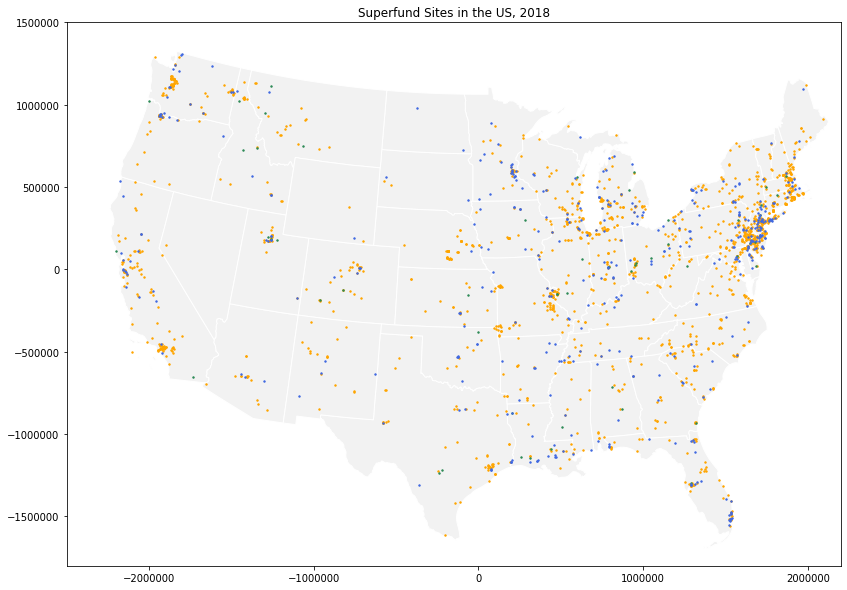

In [6]:
#plot superfund sites based on NPL status over state basemap to visualize distribution
states = gpd.read_file('http://www2.census.gov/geo/tiger/GENZ2017/shp/cb_2017_us_state_20m.zip')

#project each layer to Albers Equal Conic for visualization
states_equal = states.to_crs('+proj=aea +lat_1=20 +lat_2=60 +lat_0=40 +lon_0=-96 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs')
current_equal = current.to_crs('+proj=aea +lat_1=20 +lat_2=60 +lat_0=40 +lon_0=-96 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs')
proposed_equal = proposed.to_crs('+proj=aea +lat_1=20 +lat_2=60 +lat_0=40 +lon_0=-96 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs')
deleted_equal = deleted.to_crs('+proj=aea +lat_1=20 +lat_2=60 +lat_0=40 +lon_0=-96 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs')

#plot projected data
fig, ax = plt.subplots(figsize=(20,10))

states_equal.plot(ax=ax, edgecolor='white', color='#f2f2f2', zorder=0)
current_equal.plot(ax=ax, color='orange', zorder=1, markersize=2);
proposed_equal.plot(ax=ax, color='seagreen', zorder=1, markersize=2);
deleted_equal.plot(ax=ax, color='royalblue', zorder=1, markersize=2);


ax.set(xlim=(-2500000,2200000), ylim=(-1800000,1500000), title='Superfund Sites in the US, 2018');

print;

### EPA Superfund Site Search

I was able to find more data about each site through an advanced search on the EPA's website. The site allows for an export to excel. I included all sites that were proposed, current, and deleted from the NPL, withdrawn from the NPL, part of an NPL site, and removed from the proposed NPL.

In [7]:
# read site data it
sites = pd.read_excel('../data/superfund-site-data.xlsx')
sites.head()

,EPA ID,Site Name,City,County,State,Street Address,Zip Code,Region,NPL Status,Partial NPL Deletion,...,Site Type,Site Type Subcategory,Federal Agency,Native American Interest,Indian Entity,HRS Score,Federal Facility Indicator,Alias/Alternative Site Name,Non-NPL Status Date,Superfund Site Profile Page URL
0,NED981713837,10TH STREET SITE,COLUMBUS,PLATTE,NE,28TH AVE & 10TH ST,68601,R07,Final NPL,No,...,Other,Ground water plume site with no identifiable s...,NaN,No,NaN,28.9,No,"10TH STREET SITE, COLUMBUS PUBLIC WATER SUPPLY...",1987-02-13 00:00:00,www.epa.gov/superfund/10thstreet
1,KSD007241656,29TH & MEAD GROUND WATER CONTAMINATION,WICHITA,SEDGWICK,KS,412 E 29TH N 26S 1E SW 1/4 S 33,67219,R07,Deleted NPL,Yes,...,Other,Ground water plume site with no identifiable s...,NaN,No,NaN,NaN,No,"29TH & MEAD GROUND WATER CONTAMINATION, 29TH &...",1996-01-01 00:00:00,www.epa.gov/superfund/29thandmead
2,ALN000410750,35TH AVENUE,BIRMINGHAM,JEFFERSON,AL,3500 35TH N.,35207,R04,Proposed NPL,No,...,"Manufacturing/Processing/Maintenance, Other, O...","Coal gasification, Residential, Spill or other...",NaN,No,NaN,50.0,No,"35TH AVENUE COKE SITE, 35TH AVENUE SITE, WALTE...",2014-09-22 00:00:00,www.epa.gov/superfund/35th-avenue
3,KSD981710247,57TH AND NORTH BROADWAY STREETS SITE,WICHITA,SEDGWICK,KS,57TH & N BROADWAY STREETS,67219,R07,Final NPL,No,...,Other,Ground water plume site with no identifiable s...,NaN,No,NaN,50.0,No,"57TH AND N. BROADWAY STREETS SITE, 57TH AND NO...",1987-02-04 00:00:00,www.epa.gov/superfund/57thandbroadway
4,MDD980918387,68TH STREET DUMP/INDUSTRIAL ENTERPRISES,ROSEDALE,BALTIMORE,MD,68TH STREET,21237,R03,Proposed NPL,No,...,"Waste Management, Waste Management",Co-disposal landfill (municipal and industrial...,NaN,No,NaN,50.0,No,"68TH STREET DUMP, 68TH STREET DUMP/INDUSTRIAL ...",2003-04-30 00:00:00,www.epa.gov/superfund/68thstreet


In [8]:
list(sites.columns)

['EPA ID',
 'Site Name',
 'City',
 'County',
 'State',
 'Street Address',
 'Zip Code',
 'Region',
 'NPL Status',
 'Partial NPL Deletion',
 'Superfund Alternative Approach',
 'Site-wide Ready for Anticipated Use',
 'Human Exposure Under Control',
 'Groundwater Migration Under Control',
 'Construction Complete',
 'Construction Completion Date',
 'Non-NPL Status Category',
 'Non-NPL Status Subcategory',
 'Non-NPL Status',
 'Site Status',
 'Site Type',
 'Site Type Subcategory',
 'Federal Agency',
 'Native American Interest',
 'Indian Entity',
 'HRS Score',
 'Federal Facility Indicator',
 'Alias/Alternative Site Name',
 'Non-NPL Status Date',
 'Superfund Site Profile Page URL']

The EPA ID field can be used to join this data with the geojson of sites. I am most interested in the columns about human exposure, groundwater mitigation, and the HRS score. The HRS (hazard ranking system) is used to score contaminated sites, and sites above a 28.5 are eligible for the NPL. I also want to keek the sites profile page URL.

In [9]:
# create new dataframe with only the columns I want
sites_filter = sites.filter(['EPA ID', 'Site Type', 'NPL Status', 'Partial NPL Deletion', 'Human Exposure Under Control', 'Groundwater Migration Under Control', 'HRS Score', 'Superfund Site Profile Page URL'])
sites_filter

,EPA ID,Site Type,NPL Status,Partial NPL Deletion,Human Exposure Under Control,Groundwater Migration Under Control,HRS Score,Superfund Site Profile Page URL
0,NED981713837,Other,Final NPL,No,Yes,Yes,28.9,www.epa.gov/superfund/10thstreet
1,KSD007241656,Other,Deleted NPL,Yes,No,Yes,NaN,www.epa.gov/superfund/29thandmead
2,ALN000410750,"Manufacturing/Processing/Maintenance, Other, O...",Proposed NPL,No,Status Unavailable,Status Unavailable,50.0,www.epa.gov/superfund/35th-avenue
3,KSD981710247,Other,Final NPL,No,Yes,Yes,50.0,www.epa.gov/superfund/57thandbroadway
4,MDD980918387,"Waste Management, Waste Management",Proposed NPL,No,Yes,Yes,50.0,www.epa.gov/superfund/68thstreet
...,...,...,...,...,...,...,...,...
2398,CAD058783952,Manufacturing/Processing/Maintenance,Withdrawn,No,Status Unavailable,Status Unavailable,NaN,NaN
2399,DED980705727,Waste Management,Withdrawn,No,Status Unavailable,Status Unavailable,NaN,NaN
2400,IAD005288634,Manufacturing/Processing/Maintenance,Withdrawn,No,Status Unavailable,Status Unavailable,NaN,NaN
2401,TND981014954,Waste Management,Withdrawn,No,Status Unavailable,Status Unavailable,NaN,NaN


In [10]:
# rename columns
sites_filter = sites_filter.rename(columns = {'EPA ID':'EPASiteID',
                                               'Site Type': 'site_type',
                                               'NPL Status': 'npl_status',
                                               'Partial NPL Deletion': 'partial_npl_deletion',
                                               'Human Exposure Under Control': 'human_exposure_under_control',
                                               'Groundwater Migration Under Control': 'groundwater_mitigation_under_control',
                                               'HRS Score': 'hrs_score',
                                               'Superfund Site Profile Page URL': 'site_page_url'})

sites_filter.head()

,EPASiteID,site_type,npl_status,partial_npl_deletion,human_exposure_under_control,groundwater_mitigation_under_control,hrs_score,site_page_url
0,NED981713837,Other,Final NPL,No,Yes,Yes,28.9,www.epa.gov/superfund/10thstreet
1,KSD007241656,Other,Deleted NPL,Yes,No,Yes,NaN,www.epa.gov/superfund/29thandmead
2,ALN000410750,"Manufacturing/Processing/Maintenance, Other, O...",Proposed NPL,No,Status Unavailable,Status Unavailable,50.0,www.epa.gov/superfund/35th-avenue
3,KSD981710247,Other,Final NPL,No,Yes,Yes,50.0,www.epa.gov/superfund/57thandbroadway
4,MDD980918387,"Waste Management, Waste Management",Proposed NPL,No,Yes,Yes,50.0,www.epa.gov/superfund/68thstreet


In [11]:
# check to see how many null values we have
sites_filter.isnull().sum()

EPASiteID                                  0
site_type                                357
npl_status                                 0
partial_npl_deletion                       0
human_exposure_under_control               0
groundwater_mitigation_under_control       0
hrs_score                               1122
site_page_url                            588
dtype: int64

The additional data downloaded from the EPA's website has 2403 records, but the geojson only has 2211 features. I will use a left join to elimante the extra data that does not match to a feature. Before joining, the additional data 'sites_filter' does not have any null values for the 'npl_status' column. I will look at this column in the merged data to see if any of my original features did not match up to the joined data.

In [12]:
# join additional site data to superfund site geojson with the EPA site ID field using a left join
# to keep all the records in the original geojson, but not the etxra data for sites I do not have features for
joined_sites = pd.merge(gdf, sites_filter, on='EPASiteID', how='left')
joined_sites.head()

,siteID,EPASiteID,EPARegion,siteName,streetAddress,cityName,state,zipCode,countyName,FIPSCode,...,nonNationalPrioritiesListStatus,federalFacilityStatus,geometry,site_type,npl_status,partial_npl_deletion,human_exposure_under_control,groundwater_mitigation_under_control,hrs_score,site_page_url
0,100380,MAD001031574,1,Creese & Cook Tannery (Former),55 Clinton Avenue,Danvers,MA,01923,Essex,25009.0,...,None,N,POINT (-70.92667 42.55306),Manufacturing/Processing/Maintenance,Final NPL,No,No,Yes,60.57,www.epa.gov/superfund/creese
1,100392,MAD001041987,1,Baird & McGuire,775 South St,Holbrook,MA,02343,Norfolk,25021.0,...,None,N,POINT (-71.02861 42.14971),Manufacturing/Processing/Maintenance,Final NPL,No,Yes,Yes,66.35,www.epa.gov/superfund/baird
2,100432,MAD001197755,1,Walton & Lonsbury Inc.,78 North Avenue,Attleboro,MA,02703,Bristol,25005.0,...,None,N,POINT (-71.29694 41.95778),Manufacturing/Processing/Maintenance,Final NPL,No,Insufficient Data,Insufficient Data,58.30,www.epa.gov/superfund/walton
3,100438,MAD001403104,1,Olin Chemical,51 Eames St,Wilmington,MA,01887,Middlesex,25017.0,...,None,N,POINT (-71.15389 42.52806),Manufacturing/Processing/Maintenance,Final NPL,No,Insufficient Data,No,50.00,www.epa.gov/superfund/olin
4,100460,MAD002084093,1,GE - Housatonic River,"Between Pittsfield and Lenox, Ma",Pittsfield,MA,01201,Berkshire,25003.0,...,None,N,POINT (-73.23222 42.45027),Manufacturing/Processing/Maintenance,Proposed NPL,No,No,No,70.71,www.epa.gov/superfund/ge


In [13]:
# check for null values to see if everything matched up correctly
joined_sites.isnull().sum()

siteID                                     0
EPASiteID                                  0
EPARegion                                  0
siteName                                   0
streetAddress                              1
cityName                                   0
state                                      0
zipCode                                    3
countyName                                37
FIPSCode                                  37
congressionalDistrict                    255
nationalPrioritiesListStatus               0
nonNationalPrioritiesListStatus         2190
federalFacilityStatus                      0
geometry                                   0
site_type                                302
npl_status                                 2
partial_npl_deletion                       2
human_exposure_under_control               2
groundwater_mitigation_under_control       2
hrs_score                                968
site_page_url                            430
dtype: int

In [14]:
# view features that did not match up
nullVals = joined_sites[joined_sites['npl_status'].isnull()]
nullVals

,siteID,EPASiteID,EPARegion,siteName,streetAddress,cityName,state,zipCode,countyName,FIPSCode,...,nonNationalPrioritiesListStatus,federalFacilityStatus,geometry,site_type,npl_status,partial_npl_deletion,human_exposure_under_control,groundwater_mitigation_under_control,hrs_score,site_page_url
1264,508192,MIN000508192,5,North Bronson Industrial Subareas,N. Walker St. W/Railroad St.,Bronson,MI,49028,Branch,26023.0,...,None,N,POINT (-85.19667 41.87750),NaN,NaN,NaN,NaN,NaN,NaN,NaN
1276,506324,IND984876177,5,Third Site,Intsec of Route 32 & US Highway 421,Zionsville,IN,46077,Boone,18011.0,...,None,N,POINT (-86.26333 39.95000),NaN,NaN,NaN,NaN,NaN,NaN,NaN


There were only two features that did not match up. A detailed search for these sites did not return any info on the EPA website, so it's possible they have been removed from the system entirely. I am going to remove these from the geojson.

In [15]:
joined_sites_final = joined_sites[joined_sites['npl_status'].notna()]
joined_sites_final.head()


,siteID,EPASiteID,EPARegion,siteName,streetAddress,cityName,state,zipCode,countyName,FIPSCode,...,nonNationalPrioritiesListStatus,federalFacilityStatus,geometry,site_type,npl_status,partial_npl_deletion,human_exposure_under_control,groundwater_mitigation_under_control,hrs_score,site_page_url
0,100380,MAD001031574,1,Creese & Cook Tannery (Former),55 Clinton Avenue,Danvers,MA,01923,Essex,25009.0,...,None,N,POINT (-70.92667 42.55306),Manufacturing/Processing/Maintenance,Final NPL,No,No,Yes,60.57,www.epa.gov/superfund/creese
1,100392,MAD001041987,1,Baird & McGuire,775 South St,Holbrook,MA,02343,Norfolk,25021.0,...,None,N,POINT (-71.02861 42.14971),Manufacturing/Processing/Maintenance,Final NPL,No,Yes,Yes,66.35,www.epa.gov/superfund/baird
2,100432,MAD001197755,1,Walton & Lonsbury Inc.,78 North Avenue,Attleboro,MA,02703,Bristol,25005.0,...,None,N,POINT (-71.29694 41.95778),Manufacturing/Processing/Maintenance,Final NPL,No,Insufficient Data,Insufficient Data,58.30,www.epa.gov/superfund/walton
3,100438,MAD001403104,1,Olin Chemical,51 Eames St,Wilmington,MA,01887,Middlesex,25017.0,...,None,N,POINT (-71.15389 42.52806),Manufacturing/Processing/Maintenance,Final NPL,No,Insufficient Data,No,50.00,www.epa.gov/superfund/olin
4,100460,MAD002084093,1,GE - Housatonic River,"Between Pittsfield and Lenox, Ma",Pittsfield,MA,01201,Berkshire,25003.0,...,None,N,POINT (-73.23222 42.45027),Manufacturing/Processing/Maintenance,Proposed NPL,No,No,No,70.71,www.epa.gov/superfund/ge


In [16]:
# convert crs to WGS84 for web mapping
joined_sites_final = joined_sites_final.to_crs(epsg=4326)

# overwrite file with new projected file
joined_sites_final.to_file("../data/superfund-sites.geojson", driver='GeoJSON')

PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: '../data/superfund-sites.geojson'

### Explore some characteristics of the data

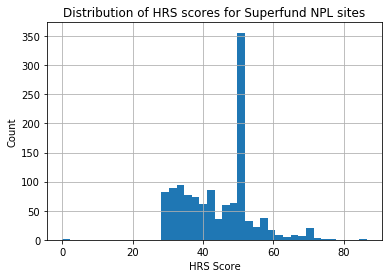

In [18]:
# plot historgram of HRS scores to view distrbution
plot = joined_sites_final['hrs_score'].hist(bins=40)
plot.set(xlabel='HRS Score', ylabel='Count', title='Distribution of HRS scores for Superfund NPL sites');

The majority of superfund sites on the NPL have a score of around 50. There are a few that have higher scores close to 80 or above. Let's see which sites those are.

In [29]:
high_scores = joined_sites.sort_values(by=['hrs_score'], ascending=False)
high_scores.head(15)

,siteID,EPASiteID,EPARegion,siteName,streetAddress,cityName,state,zipCode,countyName,FIPSCode,...,nonNationalPrioritiesListStatus,federalFacilityStatus,geometry,site_type,npl_status,partial_npl_deletion,human_exposure_under_control,groundwater_mitigation_under_control,hrs_score,site_page_url
1669,800697,UTD980951420,8,Murray Smelter,5300 S Main Street,Murray City,UT,84107,Salt Lake,49035.0,...,None,N,POINT (-111.89322 40.65980),Manufacturing/Processing/Maintenance,Proposed NPL,No,Yes,Yes,86.60,www.epa.gov/superfund/murray-smelter
1956,701639,MOD981126899,7,Big River Mine Tailings/St. Joe Minerals Corp.,Section 25 26 35 & 36 T37N R4E,Desloge,MO,63601,St. Francois,29187.0,...,None,N,POINT (-90.53934 37.87810),Waste Management,Final NPL,No,No,Not a Groundwater Site,84.91,www.epa.gov/superfund/bigrivermine
1916,705027,MON000705027,7,Washington County Lead District - Old Mines,Intersection of Highways 21 and 47,Old Mines,MO,63630,Washington,29221.0,...,None,N,POINT (-90.73833 38.07528),Mining,Final NPL,No,No,Insufficient Data,76.81,www.epa.gov/superfund/washingtoncountyoldmines
1917,705032,MON000705032,7,Washington County Lead District - Richwoods,21 Acres in Northeast Washington County,Richwoods,MO,63071,Washington,29221.0,...,None,N,POINT (-90.81426 38.16615),Mining,Final NPL,No,No,Insufficient Data,76.81,www.epa.gov/superfund/washingtoncountyrichwoods
270,200557,NJD980505416,2,Lipari Landfill,Rt 322,Pitman,NJ,08071,Gloucester,34015.0,...,None,N,POINT (-75.14193 39.72028),Waste Management,Final NPL,No,Yes,Yes,75.60,www.epa.gov/superfund/lipari
1722,901129,CAD009106527,9,McCormick & Baxter Creosoting Co.,1214 W Washington St,Stockton,CA,95203,San Joaquin,6077.0,...,None,N,POINT (-121.30663 37.94785),Manufacturing/Processing/Maintenance,Final NPL,No,Yes,Yes,74.86,www.epa.gov/superfund/mccormick-baxter
268,200552,NJD980505366,2,Helen Kramer Landfill,Jessup Mill Road,Mantua Township,NJ,08051,Gloucester,34015.0,...,None,N,POINT (-75.20030 39.78010),Waste Management,Final NPL,No,Yes,Insufficient Data,72.66,www.epa.gov/superfund/helen-kramer-landfill
139,100580,MAD076580950,1,Industri-Plex,Commerce & Atlantic,Woburn,MA,01801,Middlesex,25017.0,...,None,N,POINT (-71.14166 42.51666),Manufacturing/Processing/Maintenance,Final NPL,No,Yes,Yes,72.42,www.epa.gov/superfund/industriplex
2039,1000361,ORD009042532,10,Taylor Lumber And Treating,22125 Southwest Rock Creek Road,Sheridan,OR,97378,Yamhill,41071.0,...,None,N,POINT (-123.42694 45.09722),Manufacturing/Processing/Maintenance,Final NPL,No,Yes,Yes,71.78,www.epa.gov/superfund/taylor-lumber
1987,903424,CAD066635442,9,Stoker Company,3390 Dogwood Road,Imperial,CA,92251,Imperial,6025.0,...,None,N,POINT (-115.54444 32.91027),Other,Proposed NPL,No,Insufficient Data,Not a Groundwater Site,70.94,www.epa.gov/superfund/stoker


Out of the top 5 highest scores, 3 do not have human exposure under control, 2 have groundwater mitigation under control, 1 is not a groundwater site, and 2 do not have sufficient data to decide groundwater mitigation status. All 3 without human exposure under control are located in Missouri.

Next I want to look at these two factors in the dataset as a whole.

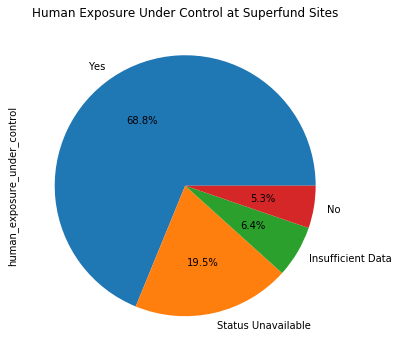

In [43]:
# the majority of sites have human exposure under control
plot = joined_sites_final['human_exposure_under_control'].value_counts().plot(kind='pie', figsize=(6, 6), autopct='%1.1f%%')
plot.set(title='Human Exposure Under Control at Superfund Sites');

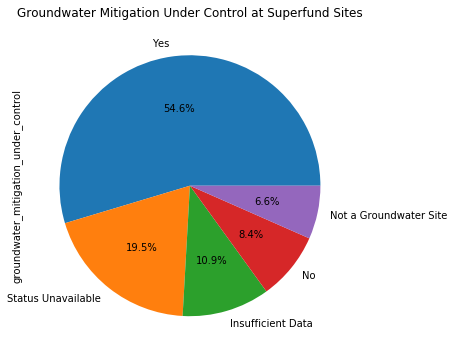

In [45]:
# the majority of sites have groundwater mitigation under control
plot = joined_sites_final['groundwater_mitigation_under_control'].value_counts().plot(kind='pie', figsize=(6, 6), autopct='%1.1f%%')
plot.set(title='Groundwater Mitigation Under Control at Superfund Sites');

Let's see what sites do not have either human exposure or groundwater mitigation under control.

In [49]:
# selecting sites that have neither groundwater mitigation nor human exposure under control
# sorting hrs scores by descending value to find worst of these sites
not_control = joined_sites_final.loc[(joined_sites_final['human_exposure_under_control'] == 'No') & (joined_sites_final['groundwater_mitigation_under_control'] == 'No')]
not_control.sort_values(['hrs_score'], ascending=False)

,siteID,EPASiteID,EPARegion,siteName,streetAddress,cityName,state,zipCode,countyName,FIPSCode,...,nonNationalPrioritiesListStatus,federalFacilityStatus,geometry,site_type,npl_status,partial_npl_deletion,human_exposure_under_control,groundwater_mitigation_under_control,hrs_score,site_page_url
4,100460,MAD002084093,1,GE - Housatonic River,"Between Pittsfield and Lenox, Ma",Pittsfield,MA,01201,Berkshire,25003.0,...,None,N,POINT (-73.23222 42.45027),Manufacturing/Processing/Maintenance,Proposed NPL,No,No,No,70.71,www.epa.gov/superfund/ge
1249,500396,ILD062340641,5,Depue/New Jersey Zinc/Mobil Chemical Corp.,Depot St & Marquette St,Depue,IL,61356,Bureau,17011.0,...,None,N,POINT (-89.30416 41.32777),"Manufacturing/Processing/Maintenance, Manufact...",Final NPL,No,No,No,70.71,www.epa.gov/superfund/depue-newjersey-zinc
1921,705443,MON000705443,7,Southwest Jefferson County Mining,"Slvr Lk Trl & Thndr Rdg Rd,.5M W Hwy Ww",Jefferson County,MO,63023,Jefferson,29099.0,...,None,N,POINT (-90.75889 38.18667),Mining,Final NPL,No,No,No,70.71,www.epa.gov/superfund/southwestjeffersoncounty...
1985,802704,UTN000802704,8,US Magnesium,"15 Miles N of Rowley Exit on I-80, 15 MI N of ...",Tooele County,UT,84029,Tooele,49045.0,...,None,N,POINT (-112.73424 40.91557),"Manufacturing/Processing/Maintenance, Mining",Final NPL,No,No,No,59.18,www.epa.gov/superfund/us-magnesium
1879,700667,KSD980741862,7,Cherokee County,Southeast Portion of The State of KS,Galena,KS,66739,Cherokee,20021.0,...,None,N,POINT (-94.72419 37.07965),Mining,Final NPL,No,No,No,58.15,www.epa.gov/superfund/cherokeecounty
2028,1000195,IDD048340921,10,Bunker Hill Mining & Metallurgical Complex,None,Smelterville,ID,83837,Shoshone,16079.0,...,None,N,POINT (-116.16170 47.54306),"Manufacturing/Processing/Maintenance, Mining",Final NPL,No,No,No,54.76,www.epa.gov/superfund/bunker-hill
731,303677,WVD024185373,3,Hanlin-Allied-Olin,State Route 2,Moundsville,WV,26041,Marshall,54051.0,...,None,N,POINT (-80.80138 39.90666),Manufacturing/Processing/Maintenance,Final NPL,No,No,No,53.98,www.epa.gov/superfund/hanlinalliedolin
1065,502194,MID000722439,5,Velsicol Chemical Corp. (Michigan),500 N Bankson Street,St. Louis,MI,48880,Gratiot,26057.0,...,None,N,POINT (-84.61861 43.41056),Manufacturing/Processing/Maintenance,Final NPL,No,No,No,52.29,www.epa.gov/superfund/velsicol-chemical-michigan
1626,800257,COD980717557,8,"Central City, Clear Creek",Near Town,Idaho Springs,CO,80452,Clear Creek,8019.0,...,None,N,POINT (-105.68504 39.77683),Mining,Final NPL,No,No,No,51.39,www.epa.gov/superfund/central-city
334,201112,NJD981557879,2,Cornell Dubilier Electronics Inc.,333 Hamilton Blvd,South Plainfield,NJ,07080,Middlesex,34023.0,...,None,N,POINT (-74.41416 40.57638),Manufacturing/Processing/Maintenance,Final NPL,No,No,No,50.27,www.epa.gov/superfund/cornell-dubilier


There are three sites that share the highest HRS score of 70.71, in Massachusetts, Illinois, and Missouri. Now I'll export the final joined dataset to geojson so I can inspect some of these sites further in QGIS.

In [50]:
# convert crs to WGS84 for web mapping
joined_sites_final = joined_sites_final.to_crs(epsg=4326)

# write joined final dataset to geojson
joined_sites_final.to_file("../data/superfund-sites.geojson", driver='GeoJSON')

## Superfund site stories

The final storymap will focus on three specific Superfund site stories. After showing all the sites on the map, I will zoom into each site with more details.

#### 1. GE-Pittsfield/Housatonic River Site

From 1932 through 1977, General Electric manufactured and serviced electrical transformers containing PCBs. Years of PCB and industrial chemical use, and improper disposal, led to extensive contamination around Pittsfield, MA as well as down the entire length of the Housatonic River.

This section will show the acutal site location, and the Housatonic River all the way down through Connecticut to visualize how far contaminants can travel.

I downloaded rivers for this area using QuickOSM, selected the Housatonic river, and exported to geojson.

#### 2. Depue/New Jersey Zinc/Mobil Chemical Corporation 

This site is where a zinc smelter and fertilizer plant was once located, is about 950 acres and covers over half the village of Depue, Illinois. Cleanup operations include contaminated soil and elevated levels of zinc, lead, arsenic, cadmium and other metals in Lake Depue.

I found a [map](https://www2.illinois.gov/epa/Documents/iepa/community-relations/new-jersey-zinc/site-map.pdf) showing the acutal outlines of this site. I want to georeference this photo and hopefully create a geojson from this.

#### 3. Missouri's Old Lead Belt

Missouri's Old Lead Belt provided about 80 percent of the lead produced in the United States and operated over hundreds of years. The area includes Jefferson, Washington, St Francois, and Madison counties in Missouri, and mining operations have also contaminated Big River which runs through the area. This area that once prospered from the mining industry now suffers from extreme poverty and significant health and environmental hazards. The map will show Big River and the 4 counties affected, with popups describing each specific site. I also want to show TRI facilities in this area that are continuing to contribute to pollution.


1. Southwest Jefferson County Mining in Jefferson County MO

This site includes all of Jefferson County, Missouri. Mine waste has contaminated soil, sediment, surface water and groundwater at the site with heavy metals, primarily lead. Mine waste has also been transported by the Big River and manually relocated to other areas throughout Jefferson County. In residential properties, this material has been used as topsoil, fill material and aggregate for roads.

2. Washington County Lead District (WCLD)

Washington County Lead District encompasses all of Washington County and includes soil, groundwater, surface water and sediment contaminated with arsenic, barium, cadmium and lead from historic mining practices. There are several sites in this district,
    1. WCLD Old Mines
    2. WCLD Richwoods
    3. WCLD Furnace Creek
    4. WCLD Potosi
    
3. Big River Mines Tailings/St. Joe Minerals Corp.

This site encompasses all of St. Francois county is contaminated with lead, cadmium and zinc from lead mining activities, and is composed of eight large areas of mine waste approximately 110 square miles in size. Surrounding residential and recreational areas are also included. In 1977, heavy rains caused an estimated 50,000 cubic yards of tailings to slough into the Big River. 

4. Madison County Mines

This site contains all of Madison County, Missouri.